# SIMTRA – Pipeline Completo de Análise e Modelagem (DNIT)Este notebook demonstra todas as etapas solicitadas:- **Tratamento de Dados**- **Análise Exploratória (EDA)**- **Regressão Linear**- **Árvore de Decisão**- **K-Means Clustering**⚠️ Coloque o arquivo `vmda2022_snv_202301b.xlsx` na mesma pasta deste notebook.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline

## 1. Carregamento e Tratamento de Dados

In [12]:
FILE_PATH = 'vmda2022_snv_202301b.xlsx'
df = pd.read_excel(FILE_PATH, sheet_name='SNV202301B')
df['VMDA_TOTAL'] = df['VMDa_C'].fillna(0) + df['VMDa_D'].fillna(0)
df.head()

,ID,id_trecho_,vl_br,sg_uf,nm_tipo_tr,sg_tipo_tr,desc_coinc,vl_codigo,ds_local_i,ds_local_f,...,D_D,E_D,F_D,G_D,H_D,I_D,J_D,VMDa_C,VMDa_D,VMDA_TOTAL
0,1,152433,116,RS,Eixo Principal,B,-,116BRS3150,ENTR RS-235 (P/NOVA PETRÓPOLIS),ENTR R. VICENTE PRIETO (PICADA CAFÉ),...,13.0,11.0,2.0,1.0,2.0,2175.0,127.0,2814.0,2818.0,5632.0
1,2,152435,116,RS,Eixo Principal,B,-,116BRS3165,ENTR VRS-873 (P/SANTA MARIA DO HERVAL),ENTR RS-326 (P/IVOTI),...,14.0,13.0,2.0,1.0,2.0,6299.0,368.0,8044.0,7259.0,15303.0
2,3,152434,116,RS,Eixo Principal,B,-,116BRS3160,ENTR R. VICENTE PRIETO (PICADA CAFÉ),ENTR VRS-873 (P/SANTA MARIA DO HERVAL),...,10.0,9.0,1.0,1.0,1.0,4901.0,286.0,6117.0,5597.0,11714.0
3,4,156939,448,RS,Eixo Principal,B,-,448BRS0010,ENTR BR-116/RS-118,INÍCIO DA CONCESSÃO,...,20.0,23.0,3.0,2.0,3.0,5225.0,218.0,5419.0,5769.0,11188.0
4,5,156362,392,RS,Eixo Principal,B,-,392BRS0130,ENTR RS-265(A) (P/CANGUÇU),ENTR RS-265(B) (P/CANCELÃO),...,2.0,232.0,142.0,5.0,66.0,575.0,30.0,1285.0,1250.0,2535.0


### Limpeza básica

In [14]:
df = df.dropna(subset=['sg_uf', 'vl_br', 'vl_extensa'])
df = df[df['vl_extensa'] > 0]
df.shape

(6345, 56)

## 2. Análise Exploratória de Dados

In [18]:
df['VMDA_TOTAL'].describe()

,VMDA_TOTAL
count,6345.000000
mean,6293.887313
std,10336.943717
min,0.000000
25%,1756.000000
50%,3251.000000
75%,6366.000000
max,148646.000000


In [24]:
df.groupby('sg_uf')['VMDA_TOTAL'].mean().sort_values(ascending=False).head(10)

,VMDA_TOTAL
sg_uf,
RJ,15568.721739
SP,15532.967213
DF,14207.577778
SC,12291.772563
SE,9684.754717
PR,8128.923788
PE,7580.538889
PB,7268.948052
RN,6257.212291


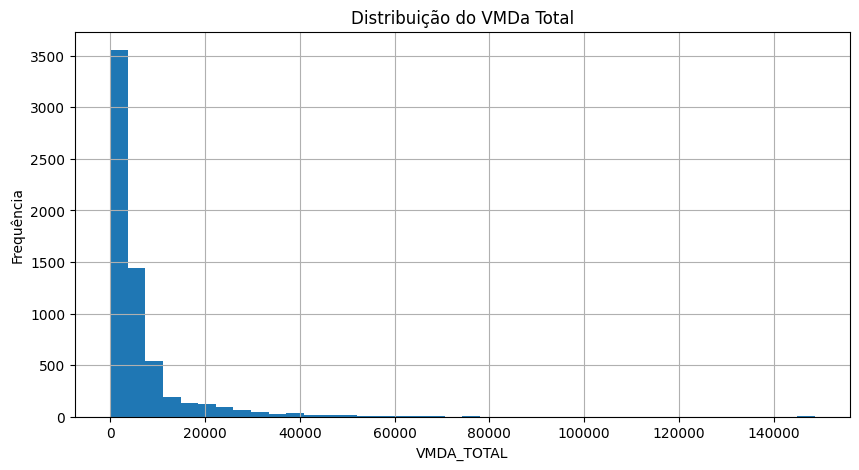

In [19]:
plt.figure(figsize=(10,5))
df['VMDA_TOTAL'].hist(bins=40)
plt.title('Distribuição do VMDa Total')
plt.xlabel('VMDA_TOTAL')
plt.ylabel('Frequência')
plt.show()

## 3. Regressão Linear – Previsão de VMDA_TOTAL

In [22]:
# Features numéricasX = df[['vl_extensa']].copy()# Encoding de UF e BRX['sg_uf'] = LabelEncoder().fit_transform(df['sg_uf'])X['vl_br'] = df['vl_br']y = df['VMDA_TOTAL']X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)model_lr = LinearRegression()model_lr.fit(X_train, y_train)model_lr.score(X_test, y_test)

le_uf = LabelEncoder()
uf_encoded = le_uf.fit_transform(df["sg_uf"].astype(str))

# Features
X = pd.DataFrame({
    "vl_extensa": df["vl_extensa"].values,
    "vl_br": df["vl_br"].values,
    "uf_encoded": uf_encoded,
})

# Target
y = df["VMDA_TOTAL"].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()

,vl_extensa,vl_br,uf_encoded
1699,12.3,265,10
57,4.8,473,22
3641,0.6,421,20
3039,9.7,153,8
6302,19.9,365,10


## 4. Árvore de Decisão – Classificação do Nível de Serviço (NS_C)

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

# Preparando target para classificação (requer a coluna 'NS_C')
# df['NS_C'] = df['NS_C'].astype(str)
# y_cls = LabelEncoder().fit_transform(df['NS_C'])
# X_cls = X.copy()
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)
# tree = DecisionTreeClassifier(max_depth=5)
# tree.fit(X_train_c, y_train_c)
# tree.score(X_test_c, y_test_c)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Previsões no teste
y_pred = model_lr.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE (Erro Quadrático Médio):", mse)
print("R² (coeficiente de determinação):", r2)

# Exemplos reais x previstos
print("\nExemplos reais x previstos:")

for i in range(5):
    print(f"Real: {y_test[i]:.1f}   |   Previsto: {y_pred[i]:.1f}")

MSE (Erro Quadrático Médio): 84233898.77732584
R² (coeficiente de determinação): 0.13561738335542095

Exemplos reais x previstos:
Real: 20065.0   |   Previsto: 8193.4
Real: 0.0   |   Previsto: -3873.4
Real: 0.0   |   Previsto: 3249.6
Real: 0.0   |   Previsto: 4572.0
Real: 2457.0   |   Previsto: 10797.3


## 5. K-Means Clustering – Agrupamento de trechos semelhantes

In [29]:
features_cluster = df[["VMDA_TOTAL", "vl_extensa"]].copy()

# Padronizar os dados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_cluster)

# Rodar o K-Means com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Adicionar clusters ao dataframe
df["cluster"] = clusters

# Mostrar primeiras linhas com o cluster
df[["sg_uf", "vl_br", "vl_extensa", "VMDA_TOTAL", "cluster"]].head()

,sg_uf,vl_br,vl_extensa,VMDA_TOTAL,cluster
0,RS,116,10.8,5632.0,0
1,RS,116,15.7,15303.0,0
2,RS,116,20.2,11714.0,3
3,RS,448,0.6,11188.0,0
4,RS,392,4.3,2535.0,0


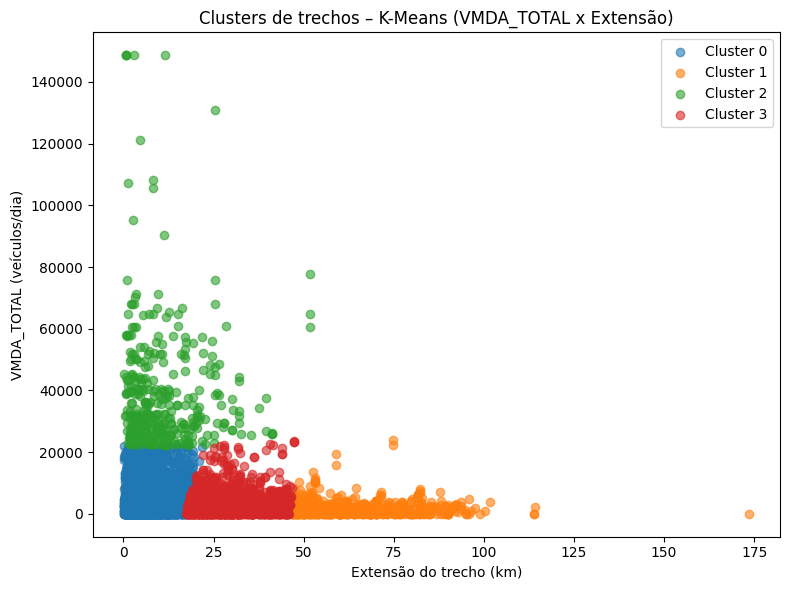

In [30]:
plt.figure(figsize=(8, 6))

for c in sorted(df["cluster"].unique()):
    d = df[df["cluster"] == c]
    plt.scatter(
        d["vl_extensa"],
        d["VMDA_TOTAL"],
        alpha=0.6,
        label=f"Cluster {c}"
    )

plt.xlabel("Extensão do trecho (km)")
plt.ylabel("VMDA_TOTAL (veículos/dia)")
plt.title("Clusters de trechos – K-Means (VMDA_TOTAL x Extensão)")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
print("Clusters identificados:", sorted(df["cluster"].unique()))
print("\nQuantidade de trechos por cluster:")
print(df["cluster"].value_counts())

print("\nValores médios por cluster:")
df.groupby("cluster")[["VMDA_TOTAL", "vl_extensa"]].mean()

Clusters identificados: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]

Quantidade de trechos por cluster:
cluster
0    3584
3    1850
1     552
2     359
Name: count, dtype: int64

Valores médios por cluster:


,VMDA_TOTAL,vl_extensa
cluster,,
0,5037.425781,7.310399
1,2191.969203,63.397917
2,39259.069638,10.868524
3,3554.923243,29.006254
